## Simulation of k-space data obtained with gradient-echo imaging pulse sequence

In [266]:
using PyPlot
addprocs(Sys.CPU_CORES-nprocs());
nprocs()

4

### Loading phantoms

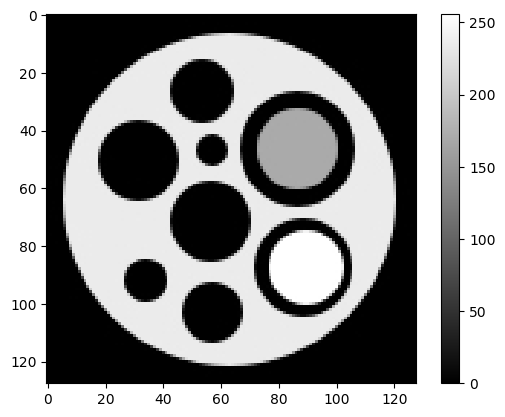

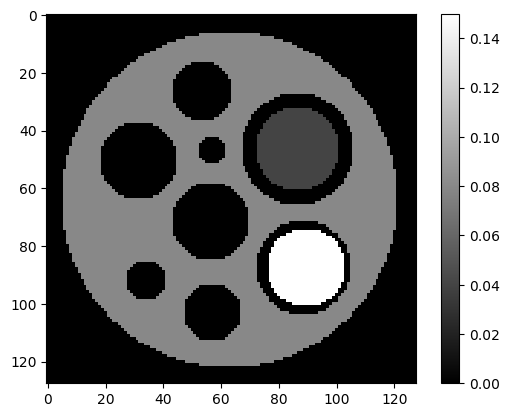

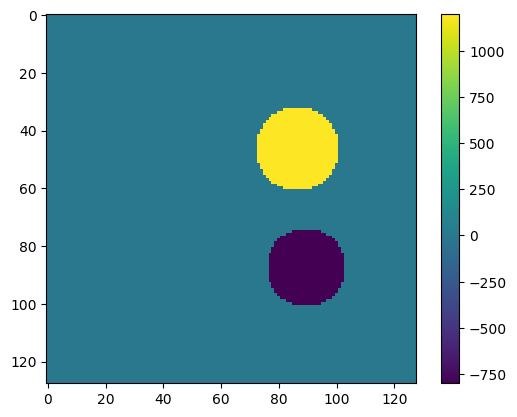

In [267]:
T2valueForM1 = 80e-3 #msec
T2valueForM2 = 40e-3 #msec
T2valueForM3 = 150e-3 #msec
B0offsetForM2 = 1200. # Hz
B0offsetForM3 = -800. # Hz

fid = open("phantoms/m1.img"); m1 = read(fid,UInt8,128*128); close(fid)
m1 = convert(Array{Float64},reshape(m1,128,128));
fid = open("phantoms/m2.img"); m2 = read(fid,UInt8,128*128); close(fid)
m2 = convert(Array{Float64},reshape(m2,128,128));
fid = open("phantoms/m3.img"); m3 = read(fid,UInt8,128*128); close(fid)
m3 = convert(Array{Float64},reshape(m3,128,128));
ProtonDensityMap = m1+m2+m3;
T2map = zeros(128,128);T2map[find(m1.>=2)]=T2valueForM1; T2map[find(m2.>=2)]=T2valueForM2; T2map[find(m3.>=3)]=T2valueForM3; 
B0offsetmap = zeros(128,128); B0offsetmap[find(m2.>=2)]=B0offsetForM2; B0offsetmap[find(m3.>=3)]=B0offsetForM3; 
figure(1);imshow(ProtonDensityMap,cmap="gray",interpolation="none");colorbar()
figure(2);imshow(T2map,cmap="gray",interpolation="none");colorbar()
figure(3);imshow(B0offsetmap,interpolation="none");colorbar()
PHANTOMSIZE = 240; # mm
xx = size(ProtonDensityMap)[1]; yy = size(ProtonDensityMap)[2];
vx = PHANTOMSIZE/xx; vy = PHANTOMSIZE/yy;
locationX = repmat(-vx*xx/2:vx:vx*xx/2-1,1,yy);
locationY = repmat((-vy*yy/2:vy:vy*yy/2-1)',xx,1);

### Scan parameters:
* The field of view (FOV) is 220 mm
* The dwell time (DW) is $50 \ \mu sec$
* Imaging matrix Size is $ 128 \times 128 $
* Pre-phasing gradient duration (d1) is 5 msec 
* Echo time (TE) is 50 msec
* Repetition time (TR) is significantly longer than T1 
* The readout bandwidth (BW) is calculated from DW
* Additional delay time (d2) will be determined by TE
* Gradient strength will be determined by the FOV and BW

In [268]:
FOV = 220.
DW = 50e-6
matrixSize = [96,96]
d1 = 5e-3 # pre-phasing gradient duration
TE = 50e-3
BW = 1/DW
ReadoutAcquisitionWindow = DW*matrixSize[1]
d2 = TE - (ReadoutAcquisitionWindow/2.)-d1
GradientX = BW/FOV   # Hz/mm
GradientYi = (GradientX*DW)/d1
GradientX1 = -GradientYi*(round(matrixSize[1]/2))
adcStartTime = d1+d2+DW
adcEndTime = d1+d2+ReadoutAcquisitionWindow;

### Computing k-trajectory for a certain TR
* kx sampling trajectory along the zero ky line

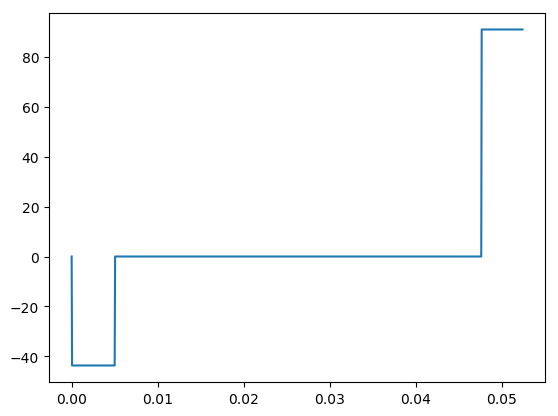

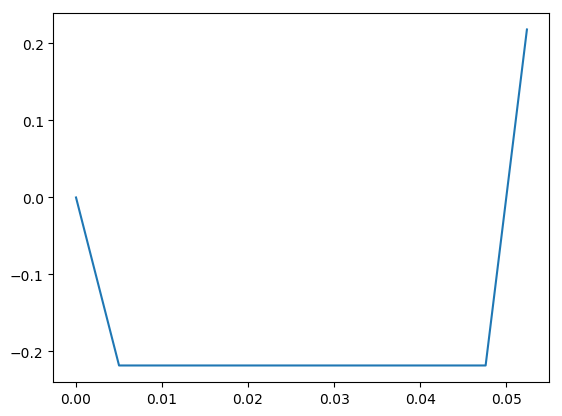

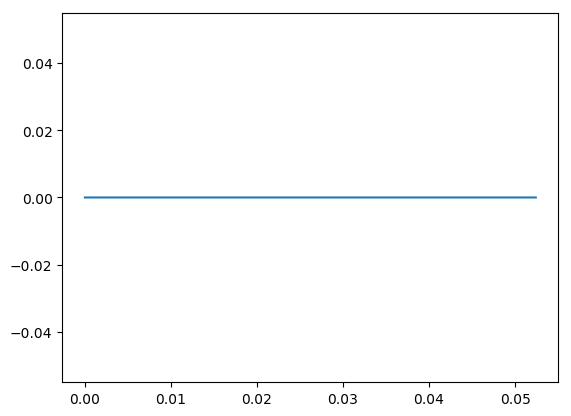

In [269]:
timeSampled = 0:DW:adcEndTime
GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
figure(1); plot(timeSampled,GxWaveform)
trajectory_kx = cumsum(GxWaveform)*DW;
figure(2); plot(timeSampled,trajectory_kx)
GyWaveform = vcat(0.,0.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
trajectory_ky = cumsum(GyWaveform)*DW;
figure(3); plot(timeSampled,trajectory_ky)
acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

### Producing 1D k-space data from a certain TR
* kx data points along the zero ky line

In [270]:
@everywhere function MRIscan(t,kx,ky,pd,T2,B0,X,Y)
    kdata = zeros(Complex{Float64},size(t))
    i = complex(0,1)
    for cnt = 1:size(t)[1]
        kdata[cnt]=sum(pd.*exp.(-t[cnt]./T2).*exp.(i*2*π*B0*t[cnt]).*exp.(i*2*π*kx[cnt].*X).*exp.(i*2*π*ky[cnt].*Y))
    end
    return kdata
end

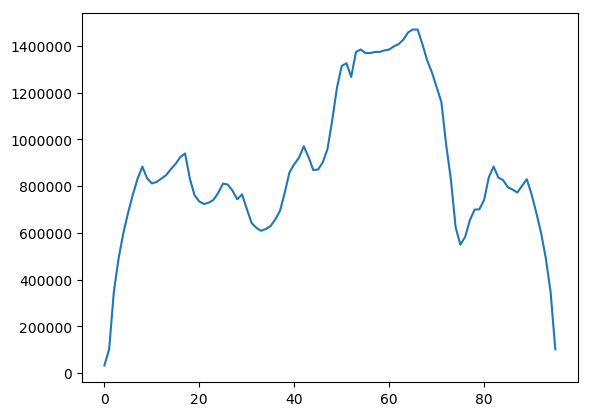

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x137fd2dd0>

In [271]:
kdata = MRIscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],B0offsetmap[:],locationX[:],locationY[:]);
imgdata = fftshift(fft(fftshift(kdata)));
plot(abs.(imgdata))

### Computing 2D k-trajectory (for all TR) and k-space data

In [272]:
# kSpaceData2D = zeros(Complex{Float64,},matrixSize[1],matrixSize[2])
kSpaceData2D = SharedArray{Complex{Float64,}}((matrixSize[1],matrixSize[2]))

timeSampled = 0:DW:adcEndTime
acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
trajectory_kx = cumsum(GxWaveform)*DW;
acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

@sync @parallel  for TRcount = 1:matrixSize[2]
    kyLocation = TRcount-round(matrixSize[2]/2)
    GyWaveform = vcat(0.,GradientYi*kyLocation.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
    trajectory_ky = cumsum(GyWaveform)*DW;
    acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
    kdata = MRIscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],B0offsetmap[:],locationX[:],locationY[:]);
    kSpaceData2D[:,TRcount] = kdata;
end


3-element Array{Future,1}:
 Future(2, 1, 125, #NULL)
 Future(3, 1, 126, #NULL)
 Future(4, 1, 127, #NULL)

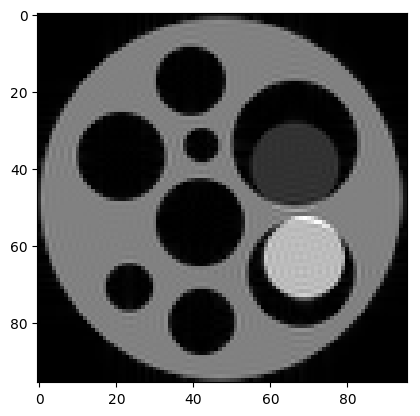

PyObject <matplotlib.image.AxesImage object at 0x135c8db10>

In [273]:
imgdata = fftshift(fft(fftshift(kSpaceData2D)));
imshow(abs.(imgdata),cmap="gray")